In [26]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import mr_forecast as mr
from astropy.io import ascii
from scipy.optimize import root_scalar

%matplotlib inline

## Definitions of fields can be found at:
### confirmed planets:
https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
### KOIs:
https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [27]:
KOIs = ascii.read("../../../../KOIs_chen2018_goodSystems.csv")
print(KOIs)
print(len(KOIs.colnames))
print(KOIs.colnames)

 kepid   kepoi_name  kepler_name  ...   koi_pmass_err1     koi_pmass_err2  
-------- ---------- ------------- ... ------------------ ------------------
 1026957  K00958.01            -- ...  5.769464972554899  3.244408578305821
 1161345  K00984.01            -- ...  6.326092545818279 3.5574232654922424
 1429589  K04923.01            -- ... 1.5735103860765358 0.7378008287493754
 1431122  K00994.01            -- ...  2.419108737036141 1.0891220900035181
 1432789  K00992.01  Kepler-745 b ...  5.964185807741979  3.027858259246558
 1432789  K00992.02            -- ...  2.437079035986733 1.0697247065679856
 1717722  K03145.01            -- ... 2.6787928971009194 1.3399128949332408
 1717722  K03145.02            -- ... 1.3217080679402717 0.6511151044108447
 1718189  K00993.03            -- ... 3.0588005877402042 1.4588377614817154
 1718189  K00993.02  Kepler-262 b ... 2.9891737858212397  1.378072373671277
     ...        ...           ... ...                ...                ...
12645057  K0

# Constraints on hypothetical in-between planets

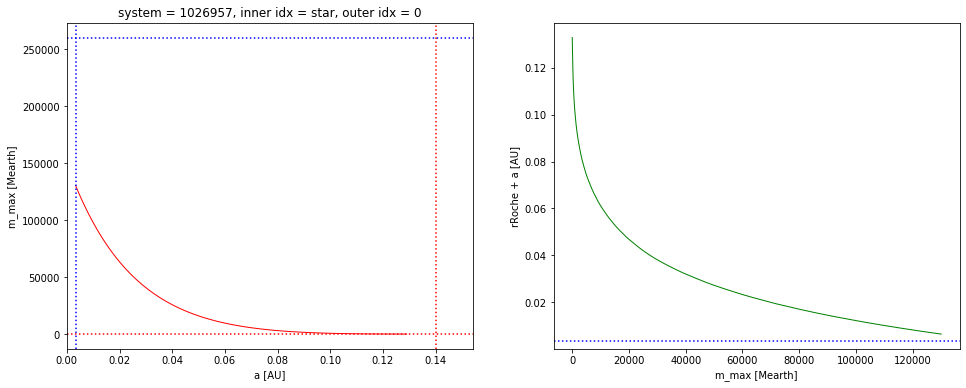

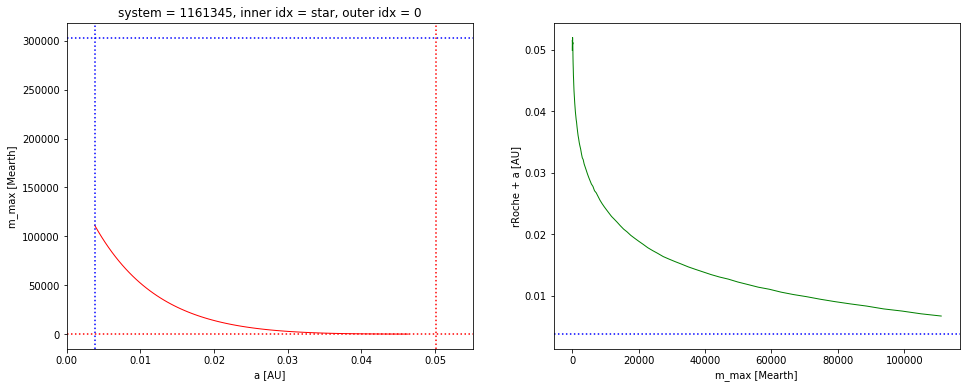

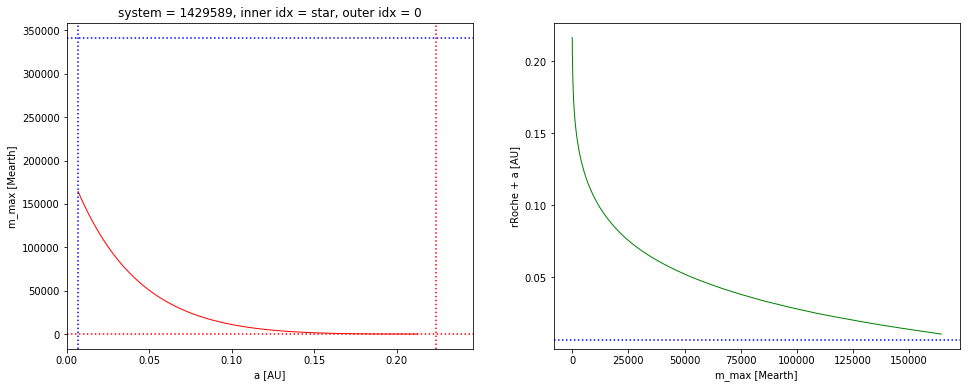

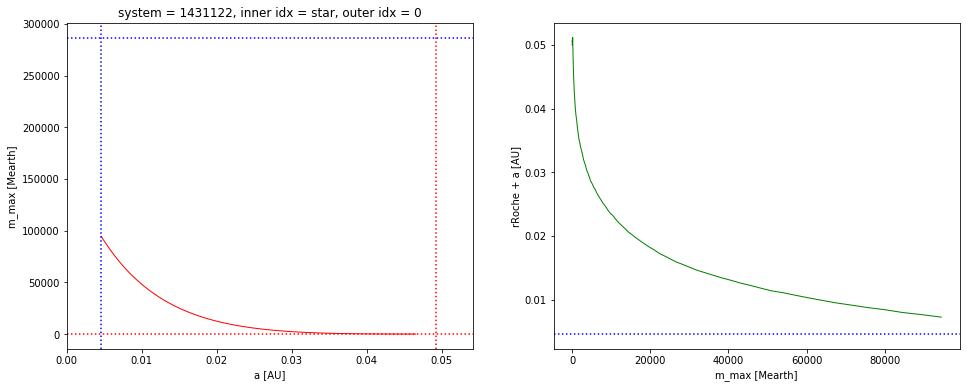

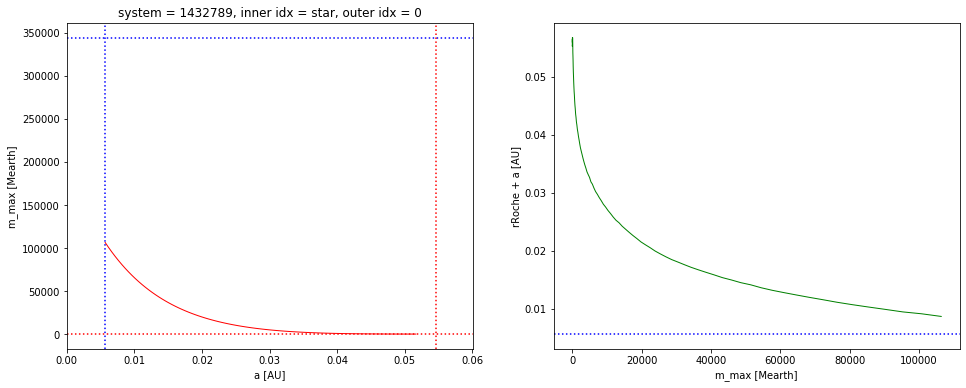

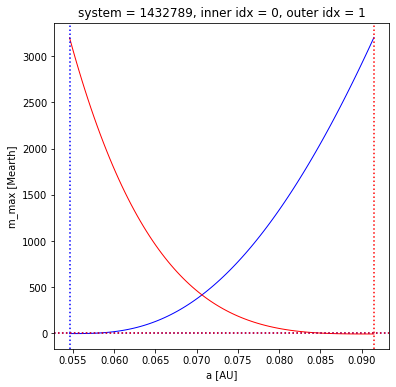

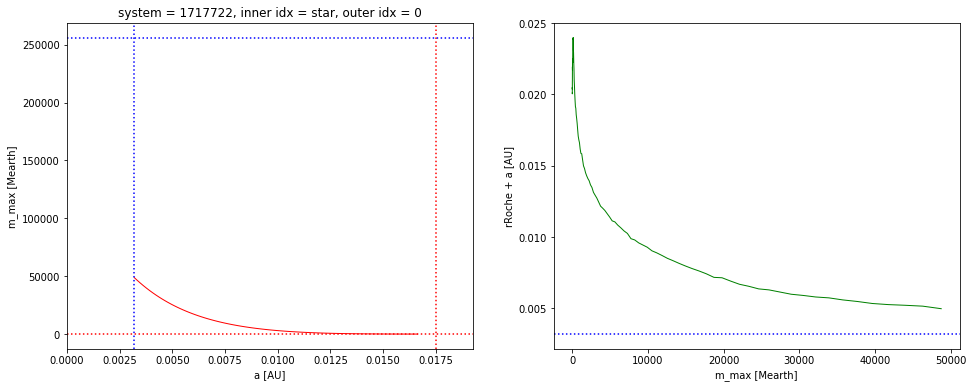

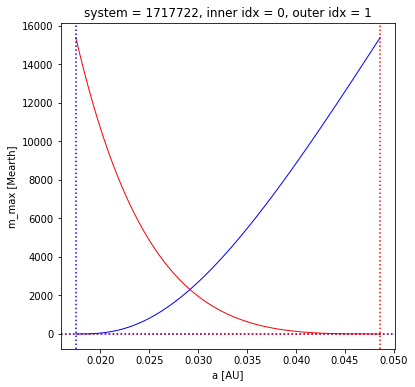

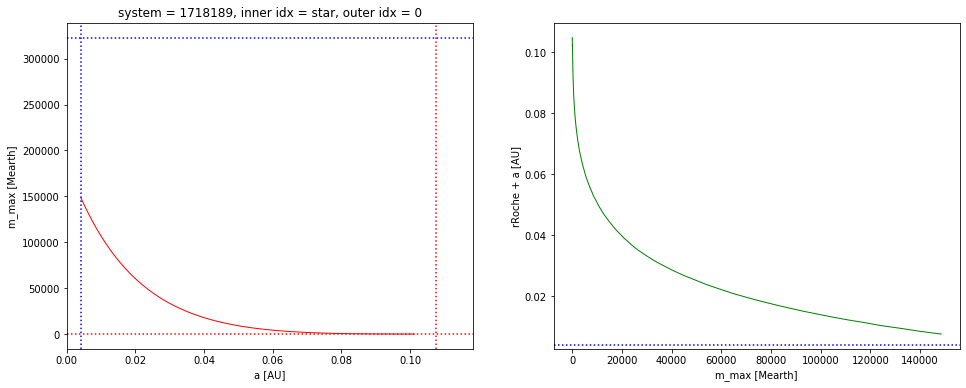

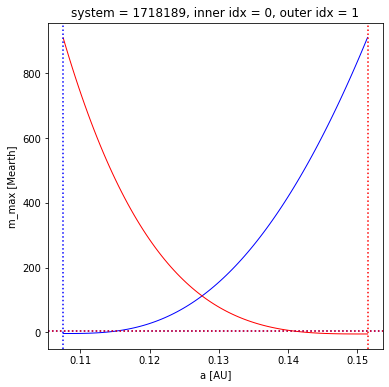

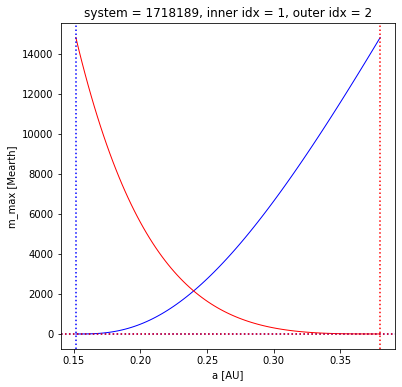

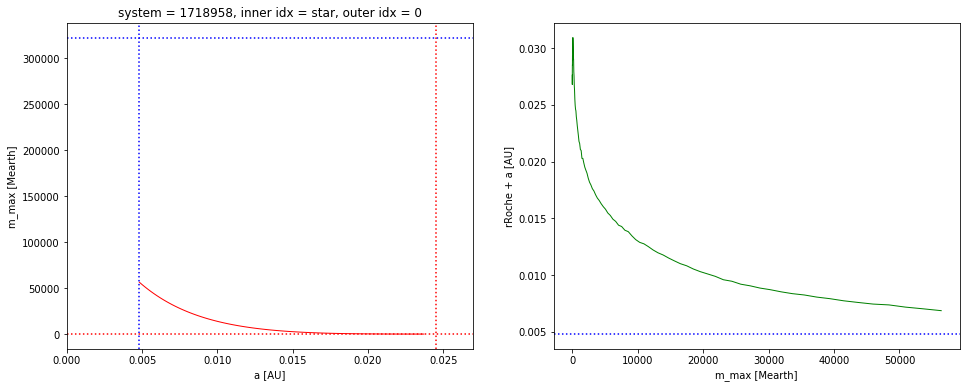

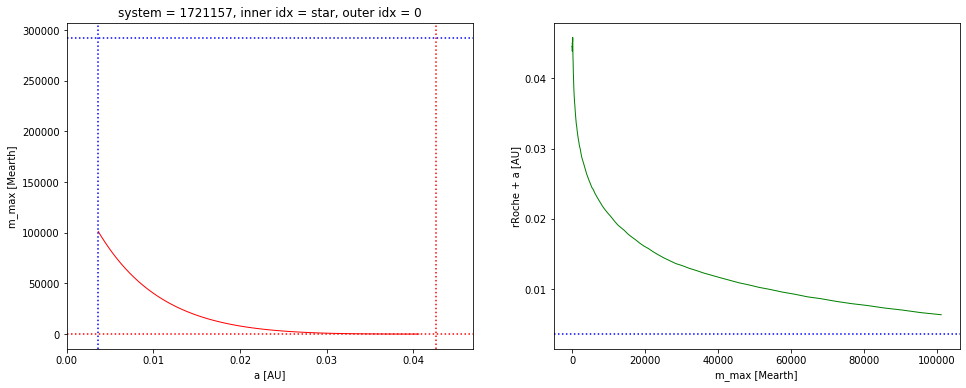

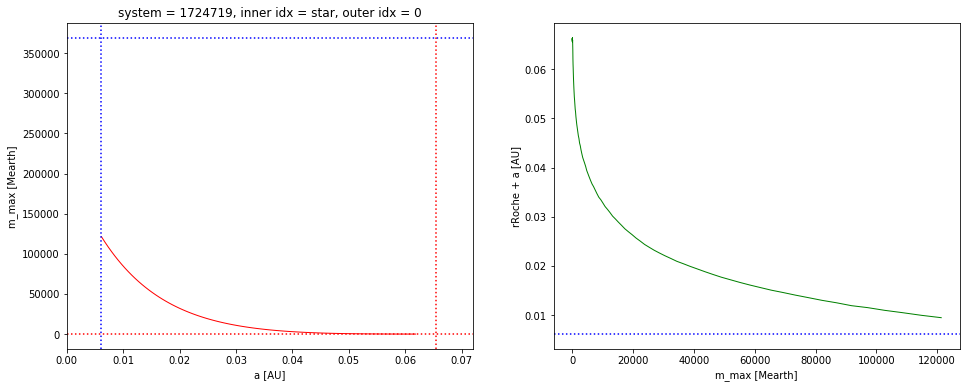

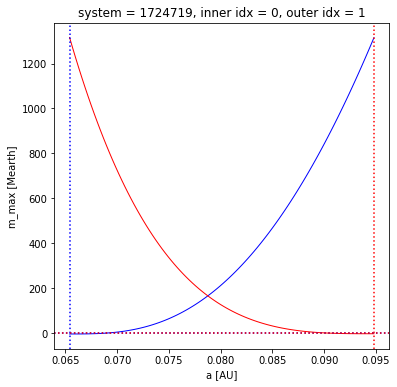

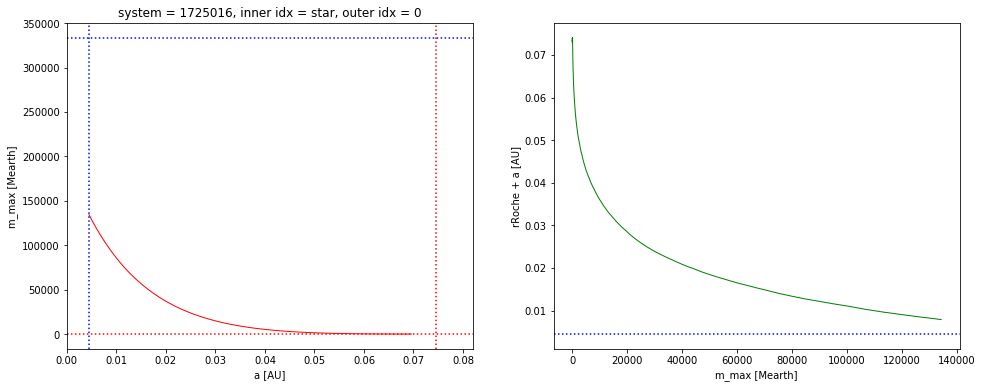

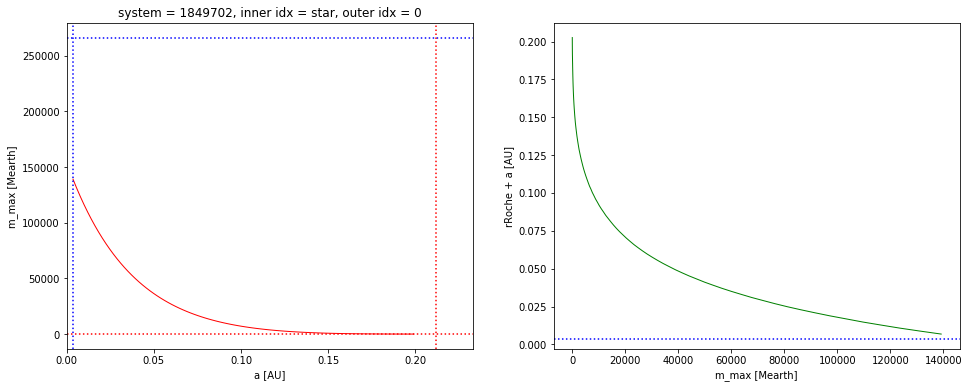

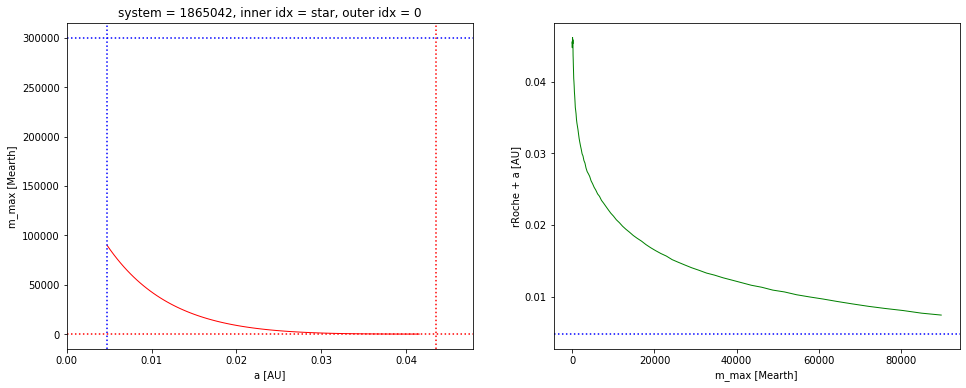

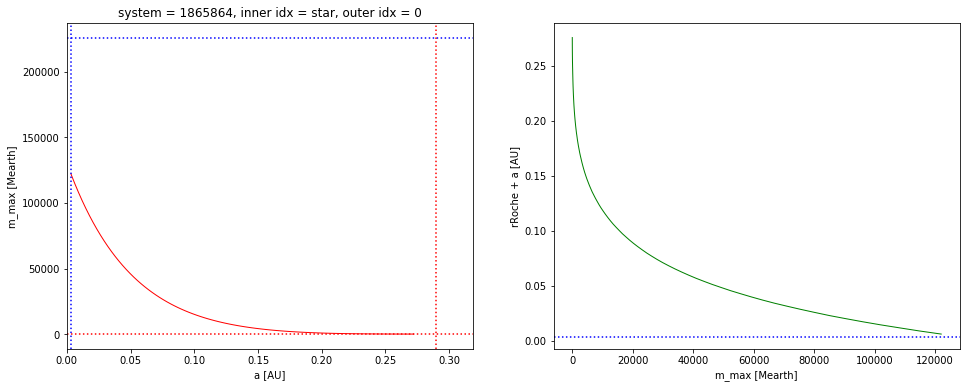

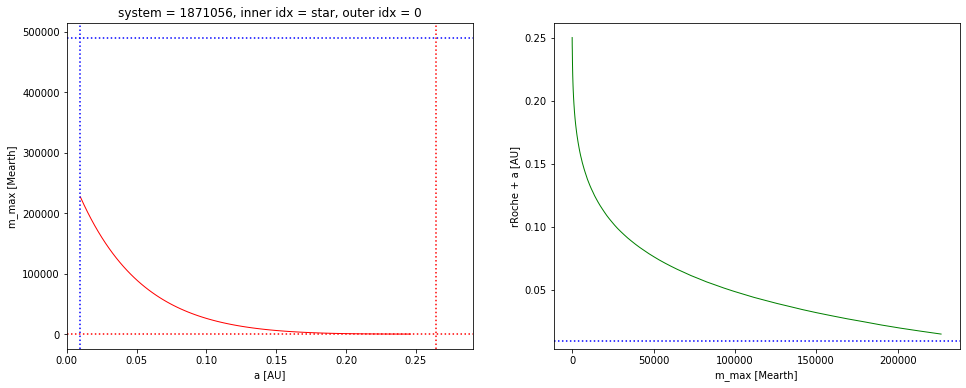

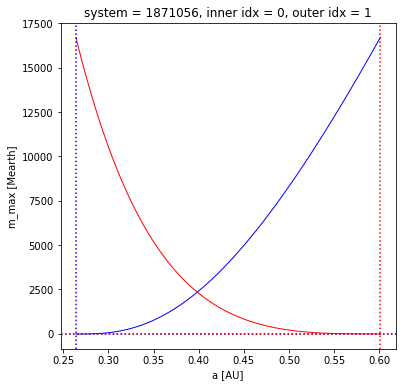

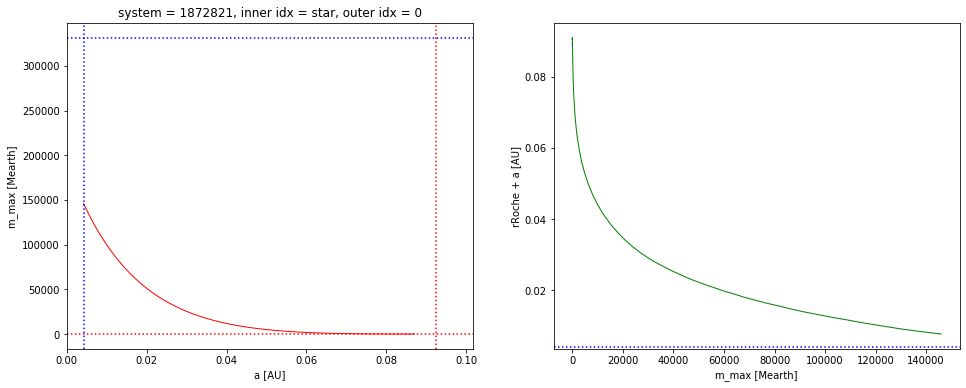

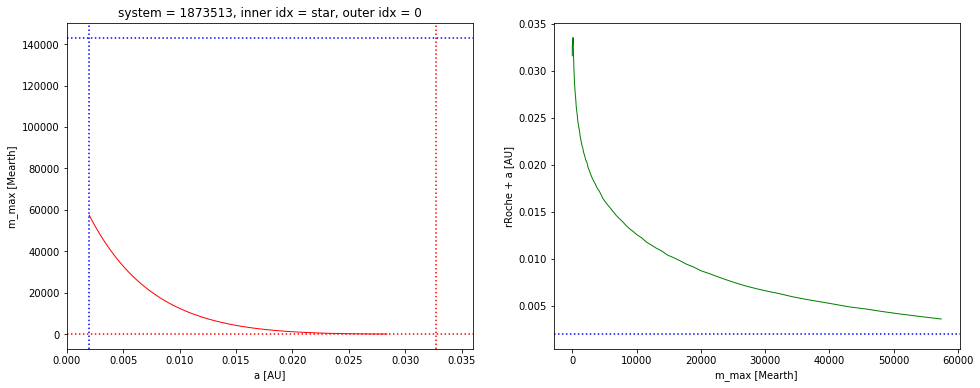

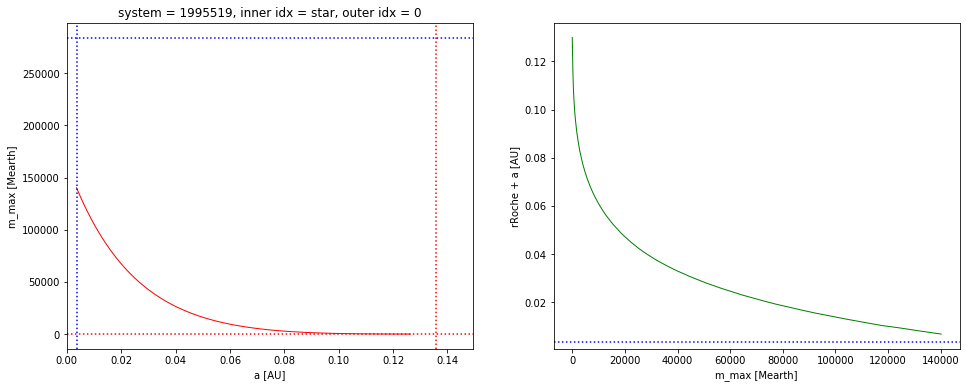

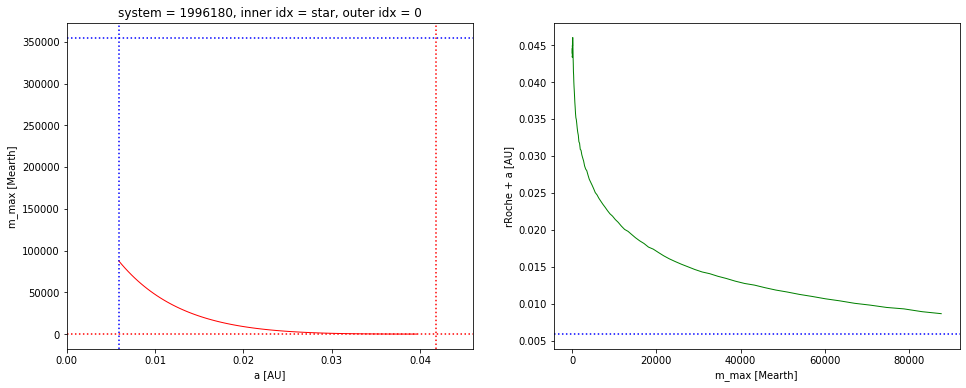

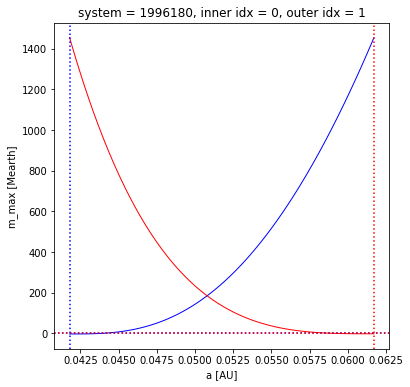

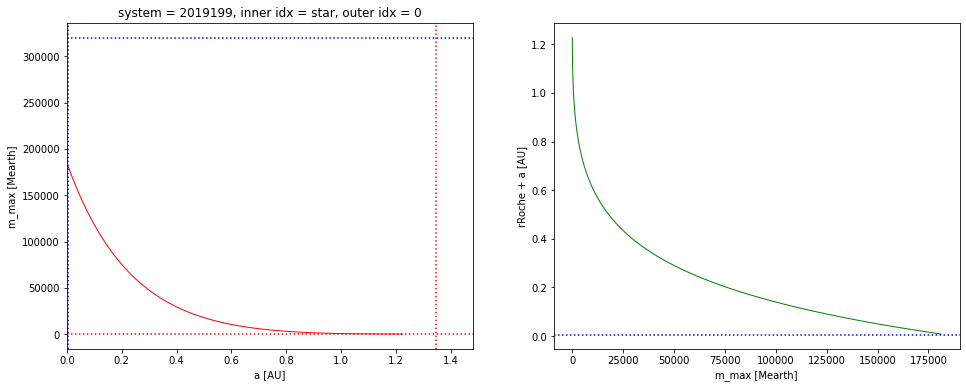

In [78]:
# For all the systems with 2+ planets, bracket Rp, P of a planet between each two observed.

# Relevant columns:
# KOIs('kepid')

# Directly observed:
# KOIs('koi_steff') [K]
# KOIs('koi_slogg') [log10cm/s]
# KOIs('koi_ror')
# KOIs('koi_period') [days] # Will bracket P_target

# Isochrone model-dependent:
# KOIs('koi_srad') [Rsun]
# KOIs('koi_smass') [Msun]
# KOIs('koi_prad') [Rearth]
# KOIs('koi_insol') [Searth]
# KOIs('koi_sma') [AU] # Will bracket a_target

# Forecaster-modeled:
# KOIs('koi_pmass') [Mearth]

# Will be calculated:
# Mutual Hill radii: will bracket Mp_target

# Will be reverse-Forecaster modeled:
# Brackets Rp_target

# want an array that looks like:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

constraints = np.zeros((1,11))
idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))

for ID in unique_kepid[0:20]:
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #constrain planet between star and 1st observed planet
    # The constraint here: we want the largest allowable planet for which the star's Roche limit 
    # exceeds Rstar + Rp.
    Ps = KOIs['koi_period'][thisSystem_idxs]
    #sort KOIs from inner to outer
    sort = np.argsort(Ps)
    thisSystem_idxs = thisSystem_idxs[sort]
    count = KOIs['koi_count'][thisSystem_idxs[0]]
    Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Msun to Earth masses
    Rstar = KOIs['koi_srad'][thisSystem_idxs[0]] * 109.2 # Rsun to Earth radii
    P_innermost = KOIs['koi_period'][thisSystem_idxs[0]]
    
    
    constrainedPlanet = np.zeros((11))
    constrainedPlanet[0] = ID
    constrainedPlanet[1] = 0
    constrainedPlanet[2] = 1
    constrainedPlanet[3] = KOIs['koi_srad'][thisSystem_idxs[0]]/215.032
    constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[0]]
    # in units of Rearth**3 Mearth**-1 d**-2
    G_ = 6.674e-11 * (1.496e11)**-3 * 5.972e24 * 86400**2
    constrainedPlanet[5] = np.sqrt( (4*np.pi**2 * Rstar**3) / (G_*Mstar) )
    constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[0]]
            
    a_inner = KOIs['koi_srad'][thisSystem_idxs[0]]/215.032 #convert solrad to AU
    a_outer = KOIs['koi_sma'][thisSystem_idxs[0]]
            
    m_inner = Mstar
    m_outer = KOIs['koi_pmass'][thisSystem_idxs[0]]
            
    a_allow = np.linspace(a_inner, a_outer, 100)
    #mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
    mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer

    # eliminate negative masses
    a_allow = a_allow[mmax_fromouter > 0]
    mmax_fromouter = mmax_fromouter[mmax_fromouter > 0]
    
    rmax_fromouter = np.zeros_like(mmax_fromouter)
    rRoche = np.zeros_like(mmax_fromouter)
    for i in range(len(mmax_fromouter)):
        rmax_fromouter[i], Rplus, Rminus = mr.Mstat2R(mean=mmax_fromouter[i], std=0.01, unit='Earth', sample_size=100)
        rRoche[i] = rmax_fromouter[i] * ( 2 * (Mstar/mmax_fromouter[i]))**(1./3.)
    
    #print(rRoche)
    fig,axes = plt.subplots(1,2,figsize=(16,6))
    #axes[0].plot(a_allow,mmax_frominner,'b-',lw=1)
    axes[0].plot(a_allow,mmax_fromouter,'r-',lw=1)
    #axes[0].plot((rRoche*((6371e3)/(1.496e11))),mmax_fromouter,'g-',lw=1)
    axes[0].axvline(a_inner,color='b',ls=':')
    axes[0].axvline(a_outer,color='r',ls=':')

    axes[0].axhline(m_inner,color='b',ls=':')
    axes[0].axhline(m_outer,color='r',ls=':')

    axes[0].set_xlabel("a [AU]")
    axes[0].set_ylabel("m_max [Mearth]")
    axes[0].set_title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,"star","0"))
    axes[0].set_xlim(0,a_outer*1.1)
    
    axes[1].plot(mmax_fromouter,(rRoche*((6371e3)/(1.496e11)))+a_allow,'g-',lw=1)
    axes[1].axhline(a_inner,color='b',ls=':')
    axes[1].set_xlabel('m_max [Mearth]')
    axes[1].set_ylabel('rRoche + a [AU]')
    
    plt.show()
    
    
    #Multi-planet systems only
    if len(thisSystem_idxs) > 1:
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Mstar = KOIs['koi_smass'][thisSystem_idxs[0]] * 333030 # Earth masses
        
        for j in range(0,count-1):
            constrainedPlanet = np.zeros((11))
            constrainedPlanet[0] = ID
            constrainedPlanet[1] = j+1
            constrainedPlanet[2] = j+2
            constrainedPlanet[3] = KOIs['koi_sma'][thisSystem_idxs[j]]
            constrainedPlanet[4] = KOIs['koi_sma'][thisSystem_idxs[j+1]]
            constrainedPlanet[5] = KOIs['koi_period'][thisSystem_idxs[j]]
            constrainedPlanet[6] = KOIs['koi_period'][thisSystem_idxs[j+1]]
            
            a_inner = KOIs['koi_sma'][thisSystem_idxs[j]]
            a_outer = KOIs['koi_sma'][thisSystem_idxs[j+1]]
            
            m_inner = KOIs['koi_pmass'][thisSystem_idxs[j]]
            m_outer = KOIs['koi_pmass'][thisSystem_idxs[j+1]]
            
            a_allow = np.linspace(a_inner, a_outer, 100)
            mmax_frominner = (Mstar/np.sqrt(3)) * ((a_allow-a_inner)/(a_allow+a_inner))**3 - m_inner
            mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a_allow)/(a_outer+a_allow))**3 - m_outer
            
            # define function to find the root of
            def mmax_overall(a,a_inner,a_outer,m_inner,m_outer,Mstar):
                mmax_frominner = (Mstar/np.sqrt(3)) * ((a-a_inner)/(a+a_inner))**3 - m_inner
                mmax_fromouter = (Mstar/np.sqrt(3)) * ((a_outer-a)/(a_outer+a))**3 - m_outer
            
                return mmax_frominner - mmax_fromouter
            
            try:
                a_mmax_obj = root_scalar(mmax_overall,args=(a_inner,a_outer,m_inner,m_outer,Mstar),bracket=(a_inner,a_outer))
                a_mmax = a_mmax_obj.root
                mmax = (Mstar/np.sqrt(3)) * ((a_mmax-a_inner)/(a_mmax+a_inner))**3 - m_inner
                
            except ValueError: #these are all gonna be negative anyway, doesn't really matter
                whichConstrains = np.argmin((mmax_frominner[0],mmax_fromouter[0]))
                if whichConstrains == 0:
                    mmax = np.max(mmax_frominner)
                else:
                    mmax = np.max(mmax_fromouter)
            
            #catch negative masses
            if mmax < 0:
                mmmax = 0
                Rmedian = 0
                Rplus = 0
                Rminus = 0
                
            else:
                try:
                    Rmedian, Rplus, Rminus = mr.Mstat2R(mean=mmax, std=0.01, unit='Earth', sample_size=100)
                except TypeError:
                    print("mmax is {0}".format(mmax))
                    Rmedian = 1000
                    Rplus = 0
                    Rminus= 0
            
            constrainedPlanet[7] = mmax
            constrainedPlanet[8] = Rmedian
            constrainedPlanet[9] = Rplus
            constrainedPlanet[10] = Rminus
            
            
            #print(mmax/317.8)#jupiter masses---i.e. is this a meaningful constraint?
            
            fig = plt.figure(figsize=(6,6))
            plt.plot(a_allow,mmax_frominner,'b-',lw=1)
            plt.plot(a_allow,mmax_fromouter,'r-',lw=1)
            plt.axvline(a_inner,color='b',ls=':')
            plt.axvline(a_outer,color='r',ls=':')
            #plt.axvline(a_mmax,color='g',ls=':')
            
            plt.axhline(m_inner,color='b',ls=':')
            plt.axhline(m_outer,color='r',ls=':')
            #plt.axhline(mmax,color='g',ls=':')
            plt.xlabel("a [AU]")
            plt.ylabel("m_max [Mearth]")
            plt.title("system = {0}, inner idx = {1}, outer idx = {2}".format(ID,j,j+1))
            
            
            constraints = np.vstack((constraints,constrainedPlanet))
    
#np.savetxt("./realKOIs_hypotheticalConstraints.txt",constraints,delimiter=" ",
#           fmt="%d %d %d %f %f %f %f %f %f %f %f",
#           header="kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr")


(857, 11)


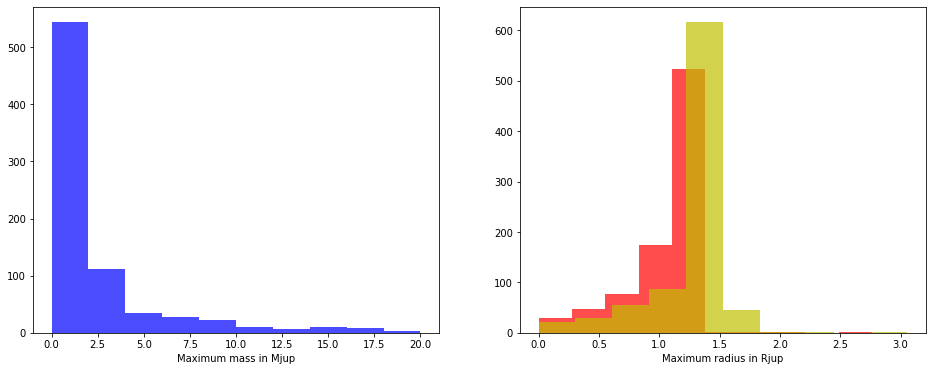

In [46]:
print(np.shape(constraints))

fig,axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(constraints[:,7]/317.8,range=(0,20),color='b',alpha=0.7)
axes[0].set_xlabel("Maximum mass in Mjup")
axes[1].hist(constraints[:,8]/11.209,color='r',alpha=0.7)
axes[1].hist((constraints[:,8]+constraints[:,9])/11.209,color='y',alpha=0.7)

axes[1].set_xlabel("Maximum radius in Rjup")
plt.show()

In [3]:
print(len(np.array(KOIs['kepid'])))
print(len(np.unique(np.array(KOIs['kepid']))))

print(len(np.array(KOIs['koi_prad'])[~np.isnan(KOIs["koi_prad"])]))
print(len(np.array(KOIs['koi_ror'])[~np.isnan(KOIs["koi_ror"])]))
print(len(np.array(KOIs['koi_insol'])[~np.isnan(KOIs["koi_insol"])]))

3512
2656
3512
3512
3512


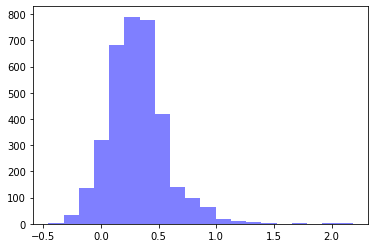

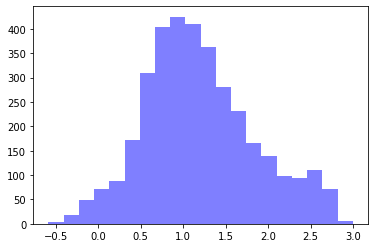

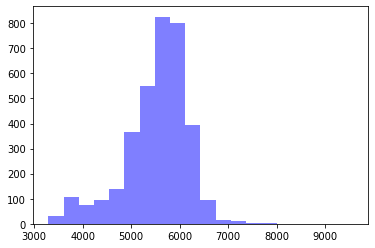

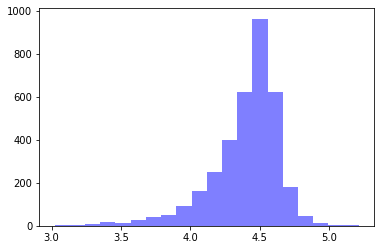

0.132
2.697


In [4]:
plt.hist(np.log10(KOIs['koi_prad']),bins=20,color='b',alpha=0.5)
plt.show()


plt.hist(np.log10(KOIs['koi_period']),bins=20,color='b',alpha=0.5)
plt.show()


plt.hist(KOIs['koi_steff'],bins=20,color='b',alpha=0.5)
plt.show()


plt.hist(KOIs['koi_slogg'],bins=20,color='b',alpha=0.5)
plt.show()


print(np.min(KOIs['koi_smass']))
print(np.max(KOIs['koi_smass']))

## Want these in a format:
### each row = 1 planetary system, i.e. a list of "planets"
### each "planet" = an array of [Rp/Rstar, P, Teff, logg, Fe/H]

In [11]:
systems = []

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.unique(np.array(KOIs['kepid']))
print(len(unique_kepid))

# Impose feature scaling!
Teff_mean = np.mean(KOIs['koi_steff'])
logg_mean = np.mean(KOIs['koi_slogg'])
#met_mean = np.mean(KOIs['koi_smet'])

#rad_mean = np.mean(np.log10(KOIs['koi_prad']))
rad_mean = np.mean(KOIs['koi_prad'])
#rad_mean = np.mean(KOIs['koi_ror'])

#period_mean = np.mean(np.log10(KOIs['koi_period']))
period_mean = np.mean(KOIs['koi_period'])

#insol_mean = np.mean(KOIs['koi_insol'])

Teff_sigma = np.std(KOIs['koi_steff'])
logg_sigma = np.std(KOIs['koi_slogg'])
#met_sigma = np.std(KOIs['koi_smet'])
#rad_sigma = np.std(np.log10(KOIs['koi_prad']))
rad_sigma = np.std(KOIs['koi_prad'])
#rad_sigma = np.std(KOIs['koi_ror'])

#period_sigma = np.std(np.log10(KOIs['koi_period']))
period_sigma = np.std(KOIs['koi_period'])

#insol_sigma = np.std(KOIs['koi_insol'])


print("means:")
#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)
print(rad_mean,period_mean,Teff_mean,logg_mean)
print("sigmas:")
#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)
print(rad_sigma,period_sigma,Teff_sigma,logg_sigma)

for ID in unique_kepid:
    goodSystem = True
    system = []
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #singles only
    #if len(thisSystem_idxs) > 1:
    #all systems
    if True:
        kepNames = KOIs['kepoi_name'][thisSystem_idxs]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
        logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
        met = KOIs['koi_smet'][thisSystem_idxs[0]]

        if np.any(np.isnan(np.array((Teff,logg,met)))):
            print(np.array((Teff,logg,met)))
            print("star nan!")
            print(ID)
            pass

        else:
            for j in range(1,count+1):
                planet = []
                planet.append( ((KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                planet.append( ((KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )
                
                planet.append( (Teff-Teff_mean)/Teff_sigma )
                planet.append( (logg-logg_mean)/logg_sigma )
                #planet.append( (met-met_mean)/met_sigma )
                if np.any(np.isnan(np.array((planet)))):
                    print(planet)
                    print("planet nan!")
                    print(ID)
                    goodSystem = False
                    pass
                else:
                    system.append((planet))

            if goodSystem is True:
                systems.append(system)

print(len(systems))

print(type(systems))
print(type(systems[0]))
print(type(systems[0][0]))

with open("realKOIs_allFeatures.txt", "wb") as picklefile:
    pickle.dump(systems, picklefile)

2656
means:
2.6804669703872435 52.02712390227676 5532.606492027335 4.396738325740319
sigmas:
5.0667190941229014 105.16387255616786 660.621410145989 0.2503844154525694
2656
<class 'list'>
<class 'list'>
<class 'list'>


In [12]:
with open("realKOIs_allFeatures.txt", "rb") as picklefile:
    systest = pickle.load(picklefile)

print(len(systest))
print(type(systest))
print(type(systest[0]))
print(type(systest[0][0]))
print(systest[0:2])
print(systems[0:2])

2656
<class 'list'>
<class 'list'>
<class 'list'>
[[[-0.02969712107422268, -0.28779679795560814, -1.0196558598948167, 0.8597247311522795]], [[-0.0770650519860401, -0.4539549187557646, -0.3581574687006401, 0.7159458145015346]]]
[[[-0.02969712107422268, -0.28779679795560814, -1.0196558598948167, 0.8597247311522795]], [[-0.0770650519860401, -0.4539549187557646, -0.3581574687006401, 0.7159458145015346]]]


# Divide into 70% training, 30% test data

In [13]:
systems = []

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.unique(np.array(KOIs['kepid']))
print(len(unique_kepid))

np.random.seed(42)
np.random.shuffle(unique_kepid)

unique_kepid_70 = unique_kepid[:int(0.7*len(unique_kepid))]
unique_kepid_30 = unique_kepid[int(0.7*len(unique_kepid)):]

print(len(unique_kepid_70))
print(len(unique_kepid_30))


print("means:")
#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)
print(rad_mean,period_mean,Teff_mean,logg_mean)
print("sigmas:")
#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)
print(rad_sigma,period_sigma,Teff_sigma,logg_sigma)

for ID in unique_kepid_70:
    goodSystem = True
    system = []
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #singles only
    #if len(thisSystem_idxs) > 1:
    #all systems
    if True:
        kepNames = KOIs['kepoi_name'][thisSystem_idxs]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
        logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
        met = KOIs['koi_smet'][thisSystem_idxs[0]]

        if np.any(np.isnan(np.array((Teff,logg,met)))):
            print(np.array((Teff,logg,met)))
            print("star nan!")
            print(ID)
            pass

        else:
            for j in range(1,count+1):
                planet = []
                planet.append( ((KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                planet.append( ((KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )
                
                planet.append( (Teff-Teff_mean)/Teff_sigma )
                planet.append( (logg-logg_mean)/logg_sigma )
                #planet.append( (met-met_mean)/met_sigma )
                if np.any(np.isnan(np.array((planet)))):
                    print(planet)
                    print("planet nan!")
                    print(ID)
                    goodSystem = False
                    pass
                else:
                    system.append((planet))

            if goodSystem is True:
                systems.append(system)

print(len(systems))
with open("realKOIs_allFeatures_70percent.txt", "wb") as picklefile:
    pickle.dump(systems, picklefile)
    
systems = []   
for ID in unique_kepid_30:
    goodSystem = True
    system = []
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    #singles only
    #if len(thisSystem_idxs) > 1:
    #all systems
    if True:
        kepNames = KOIs['kepoi_name'][thisSystem_idxs]
        Ps = KOIs['koi_period'][thisSystem_idxs]
        #sort KOIs from inner to outer
        sort = np.argsort(Ps)
        thisSystem_idxs = thisSystem_idxs[sort]

        count = KOIs['koi_count'][thisSystem_idxs[0]]

        Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
        logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
        met = KOIs['koi_smet'][thisSystem_idxs[0]]

        if np.any(np.isnan(np.array((Teff,logg,met)))):
            print(np.array((Teff,logg,met)))
            print("star nan!")
            print(ID)
            pass

        else:
            for j in range(1,count+1):
                planet = []
                planet.append( ((KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                planet.append( ((KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )
                
                planet.append( (Teff-Teff_mean)/Teff_sigma )
                planet.append( (logg-logg_mean)/logg_sigma )
                #planet.append( (met-met_mean)/met_sigma )
                if np.any(np.isnan(np.array((planet)))):
                    print(planet)
                    print("planet nan!")
                    print(ID)
                    goodSystem = False
                    pass
                else:
                    system.append((planet))

            if goodSystem is True:
                systems.append(system)
print(len(systems))
with open("realKOIs_allFeatures_30percent.txt", "wb") as picklefile:
    pickle.dump(systems, picklefile)

2656
1859
797
means:
2.6804669703872435 52.02712390227676 5532.606492027335 4.396738325740319
sigmas:
5.0667190941229014 105.16387255616786 660.621410145989 0.2503844154525694
1859
797


## Bootstrapped versions of training set

In [8]:
"""
idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.unique(np.array(KOIs['kepid']))
print(len(unique_kepid))

np.random.seed(42)
np.random.shuffle(unique_kepid)

unique_kepid_70 = unique_kepid[:int(0.7*len(unique_kepid))]
#unique_kepid_30 = unique_kepid[int(0.7*len(unique_kepid)):]

print(len(unique_kepid_70))


print("means:")
#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)
print(rad_mean,period_mean,Teff_mean,logg_mean)
print("sigmas:")
#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)
print(rad_sigma,period_sigma,Teff_sigma,logg_sigma)

for b in range(100):
    systems = []

    bootstrapped_kepid_70 = np.random.choice(unique_kepid_70,size=len(unique_kepid_70),replace=True)

    for ID in bootstrapped_kepid_70:
        goodSystem = True
        system = []
        thisSystem_mask = (kepids == ID)
        thisSystem_idxs = idxs[thisSystem_mask]

        #singles only
        #if len(thisSystem_idxs) > 1:
        #all systems
        if True:
            kepNames = KOIs['kepoi_name'][thisSystem_idxs]
            Ps = KOIs['koi_period'][thisSystem_idxs]
            #sort KOIs from inner to outer
            sort = np.argsort(Ps)
            thisSystem_idxs = thisSystem_idxs[sort]

            count = KOIs['koi_count'][thisSystem_idxs[0]]

            Teff = KOIs['koi_steff'][thisSystem_idxs[0]]
            logg = KOIs['koi_slogg'][thisSystem_idxs[0]]
            met = KOIs['koi_smet'][thisSystem_idxs[0]]

            if np.any(np.isnan(np.array((Teff,logg,met)))):
                print(np.array((Teff,logg,met)))
                print("star nan!")
                print(ID)
                pass

            else:
                for j in range(1,count+1):
                    planet = []
                    planet.append( ((KOIs['koi_prad'][thisSystem_idxs[j-1]]) - rad_mean)/rad_sigma )
                    planet.append( ((KOIs['koi_period'][thisSystem_idxs[j-1]]) - period_mean)/period_sigma )
                    #planet.append( ((KOIs['koi_insol'][thisSystem_idxs[j-1]]) - insol_mean)/insol_sigma )

                    planet.append( (Teff-Teff_mean)/Teff_sigma )
                    planet.append( (logg-logg_mean)/logg_sigma )
                    #planet.append( (met-met_mean)/met_sigma )
                    if np.any(np.isnan(np.array((planet)))):
                        print(planet)
                        print("planet nan!")
                        print(ID)
                        goodSystem = False
                        pass
                    else:
                        system.append((planet))

                if goodSystem is True:
                    systems.append(system)

    print(len(systems))
    with open("realKOIs_allFeatures_70percent_bootstrap{0}.txt".format(b), "wb") as picklefile:
        pickle.dump(systems, picklefile)
"""

'\nidxs = np.arange(len(KOIs[\'kepid\']))\nkepids = np.array(KOIs[\'kepid\'])\nunique_kepid = np.unique(np.array(KOIs[\'kepid\']))\nprint(len(unique_kepid))\n\nnp.random.seed(42)\nnp.random.shuffle(unique_kepid)\n\nunique_kepid_70 = unique_kepid[:int(0.7*len(unique_kepid))]\n#unique_kepid_30 = unique_kepid[int(0.7*len(unique_kepid)):]\n\nprint(len(unique_kepid_70))\n\n\nprint("means:")\n#print(rad_mean,period_mean,insol_mean,Teff_mean,logg_mean,met_mean)\nprint(rad_mean,period_mean,Teff_mean,logg_mean)\nprint("sigmas:")\n#print(rad_sigma,period_sigma,insol_sigma,Teff_sigma,logg_sigma,met_sigma)\nprint(rad_sigma,period_sigma,Teff_sigma,logg_sigma)\n\nfor b in range(100):\n    systems = []\n\n    bootstrapped_kepid_70 = np.random.choice(unique_kepid_70,size=len(unique_kepid_70),replace=True)\n\n    for ID in bootstrapped_kepid_70:\n        goodSystem = True\n        system = []\n        thisSystem_mask = (kepids == ID)\n        thisSystem_idxs = idxs[thisSystem_mask]\n\n        #singles 

In [9]:
print(2079 + 2*384 + 3*129 + 4*44 + 5*18 + 6*2)

3512


In [10]:
print(2079+384+129+44+18+2)

2656


In [14]:
#number of *planets* in training and test, respectively
print(2459+1053)

3512
